In [1]:
import pandas as pd
import itertools
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.text import Text
import textwrap
import matplotlib.patches as mpatches
from matplotlib.path import Path


In [2]:
# variables
path_excel = r'data.xlsx'
sheet_name = 'cactus_data'
file_path = r'images/Figure7 fulllifecycle_cost_comparison new.pdf'
dpi = 700

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 14

colors = [
    '#FFD580', # light orange color
    '#90EE90', # light green color
    '#FF69B4', #  pink color
]

In [3]:
df = pd.read_excel(
    path_excel, 
    sheet_name=sheet_name,
)

filterExceptNarok = df.city != 'Narok town'
df_except_narok = df[filterExceptNarok]

filtertNarok = df.city == 'Narok town'
df_narok = df[filtertNarok]

# print(df_narok)

In [4]:
def getTachsByComponentName(df, name):
    filter = df.component == name
    return list(df[filter]['tach'])

In [5]:
def getLifecycleCostsbyCombination(df, container_name, transport_name, treatment_name, place, color):
    container = getTachsByComponentName(df, container_name)
    e_and_t = getTachsByComponentName(df, transport_name)
    treatment = getTachsByComponentName(df, treatment_name)

    combinations = list(itertools.product(container, e_and_t, treatment))    
    sum_array = [round(sum(combination),0) for combination in combinations]  
    sum_array = list(set(sum_array))
    
    name = f"{container_name}, {transport_name} and {treatment_name}"
    if place:
        name = f"{name}, {place}"
    names = np.full(len(sum_array), name)
    
    result_df = pd.DataFrame({'name': names, 'tach': sum_array, 'color': color})

    return result_df

combinations = [
    # FSM
    [ df_except_narok, 'Infiltrating pit', 'Wheels - Machine Powered', 'Machine-powered aerobic waste water', colors[0]],
    [ df_except_narok, 'Infiltrating pit', 'Wheels - Machine Powered', 'Passive aerobic waste water', colors[1]],
    [ df_narok, 'Infiltrating pit', 'Wheels - Machine Powered', 'Anaerobic wastewater', 'Narok town' , colors[2]],
        [ df_except_narok, 'Sealed tank without infiltration structure', 'Wheels - Machine Powered', 'Machine-powered aerobic waste water', colors[0]],
    [ df_except_narok, 'Sealed tank without infiltration structure', 'Wheels - Machine Powered', 'Passive aerobic waste water', colors[1]],
    [ df_except_narok, 'Sealed tank with infiltration structure', 'Wheels - Machine Powered', 'Machine-powered aerobic waste water', colors[0]],
    [ df_except_narok, 'Sealed tank with infiltration structure', 'Wheels - Machine Powered', 'Passive aerobic waste water', colors[1]],
    [ df_narok, 'Sealed tank with infiltration structure', 'Wheels - Machine Powered', 'Anaerobic wastewater', 'Narok town' , colors[2]],
    # sewer
    [ df_except_narok, 'Direct', 'Pipes - conventional, combined, with pumping', 'Machine-powered aerobic waste water', colors[0]],
    [ df_except_narok, 'Direct', 'Pipes - conventional, combined, with pumping', 'Passive aerobic waste water', colors[1]],
    [ df_except_narok, 'Direct', 'Pipes - conventional, separate, with pumping', 'Machine-powered aerobic waste water', colors[0]],
    [ df_except_narok, 'Direct', 'Pipes - conventional, separate, with pumping', 'Passive aerobic waste water', colors[1]],
    [ df_except_narok, 'Direct', 'Pipes - conventional, separate, no pumping', 'Machine-powered aerobic waste water', colors[0]],
    [ df_except_narok, 'Direct', 'Pipes - conventional, separate, no pumping', 'Passive aerobic waste water', colors[1]],
    [ df_narok, 'Direct', 'Pipes - conventional, separate, no pumping', 'Anaerobic wastewater', 'Narok town', colors[2]],
]

dfs = []
for combination in combinations:
    df_original = combination[0]
    container = combination[1]
    transport = combination[2]
    treatment = combination[3]
    color = combination[4]
    
    place = None
    if len(combination) == 6:
        place = combination[4]
        color = combination[5]
    df_combination = getLifecycleCostsbyCombination(df_original, container, transport, treatment, place, color)
    
    if container == 'Direct' and place == 'Narok town':
        row_to_append = pd.DataFrame({'name': [list(df_combination['name'])[0]], 'tach': [623]})
        df_combination = pd.concat([df_combination, row_to_append], ignore_index=True)
    dfs.append(df_combination)

df = pd.concat(dfs, axis=0)

print(df)
    

                                                 name    tach    color
0   Infiltrating pit, Wheels - Machine Powered and...    87.0  #FFD580
1   Infiltrating pit, Wheels - Machine Powered and...    90.0  #FFD580
2   Infiltrating pit, Wheels - Machine Powered and...    92.0  #FFD580
3   Infiltrating pit, Wheels - Machine Powered and...    96.0  #FFD580
4   Infiltrating pit, Wheels - Machine Powered and...   101.0  #FFD580
..                                                ...     ...      ...
54  Direct, Pipes - conventional, separate, no pum...  1020.0  #90EE90
55  Direct, Pipes - conventional, separate, no pum...   893.0  #90EE90
56  Direct, Pipes - conventional, separate, no pum...  1279.0  #90EE90
0   Direct, Pipes - conventional, separate, no pum...  6022.0  #FF69B4
1   Direct, Pipes - conventional, separate, no pum...   623.0      NaN

[3796 rows x 3 columns]


In [6]:
def showLabel(ax, x, y, value, index):
    if index == 0:
        # 上段
        if value < 6000:
            return
    else:
        # 下段
        if value > 1750:
            return
    ax.text(x, y, f"{value:.0f}", ha='center', va='center', fontsize=12)

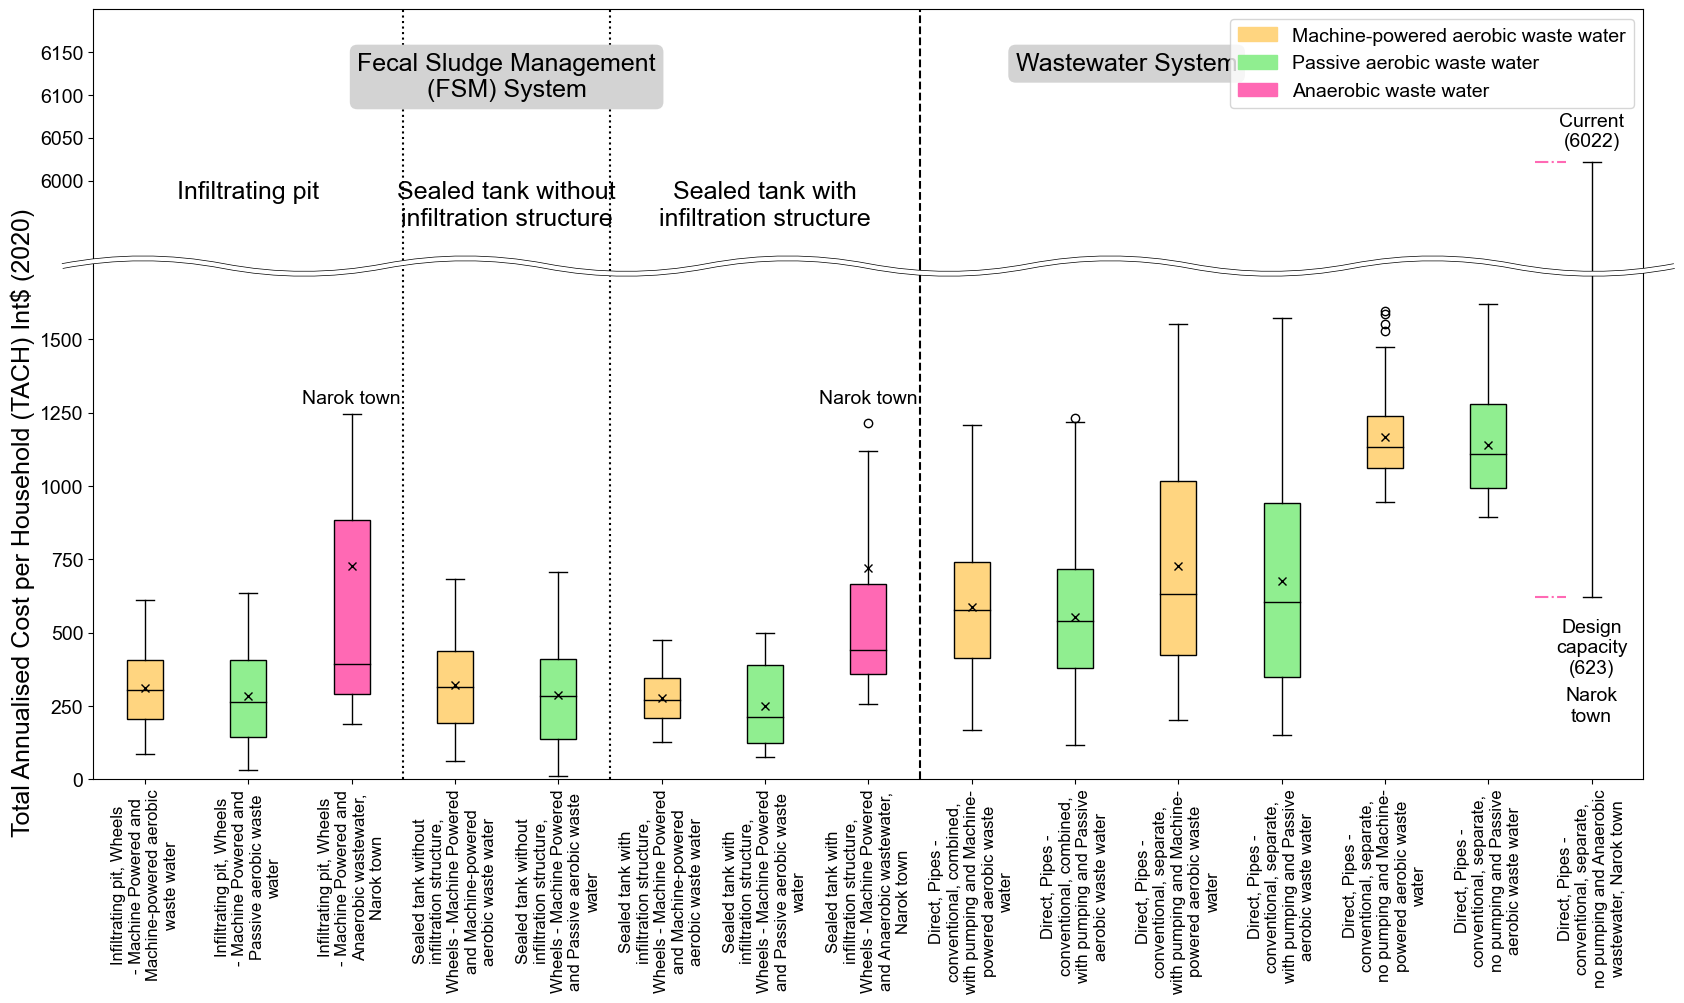

In [30]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 10), sharex='col',
                       gridspec_kw={'height_ratios': (1,2)} )

fig.patch.set_facecolor('white') # 背景色を「白」に設定

groups = df.groupby('name', sort=False)
group_labels = list(groups.groups.keys())

for index, ax in enumerate(axs):
    for j, group in enumerate(groups):
        tach = group[1]['tach']
        color = group[1]['color'][0]
        size = len(tach)
        position = j + 1
        
        linestyle = '-'
        
        name = list(group[1]['name'])[0]
        
#         if 'Narok town' in name:
#             linestyle = '--'
        
        if size == 1:
            ax.plot(position, tach, marker='o', color='k', markersize=6)
        else:
            bp = ax.boxplot(
                tach, 
                positions=[position],
                patch_artist=True,
                boxprops={'linestyle': linestyle},
                whiskerprops={'linestyle': linestyle},
                capprops={'linestyle': linestyle},
                showmeans= True, 
                meanprops = {'marker': 'x', 'markerfacecolor': 'k', 'markeredgecolor':'k', 'markersize': 6},
                showfliers = True,
                widths=0.35
            )

            for box in bp['boxes']:
                box.set_facecolor(color)
            
            # make median line black
            for median in bp['medians']:
                median.set_color('black')
            
#             med = np.median(tach)
#             showLabel(ax, position, med - 40, med, index)
            
#             mean = np.mean(tach)
#             showLabel(ax, position - 0.33, mean, mean, index)
            
       
#             q1, q3 = np.percentile(tach, [25, 75])
#             showLabel(ax, position + 0.38, q1, q1, index)
#             showLabel(ax, position + 0.38, q3, q3, index)
                
#             for i, box in enumerate(bp['boxes']):
#                 x_pos = box.get_xdata().mean()
                
#                 # get values from boxplot
#                 cap_min, cap_max = [cap.get_ydata()[1] for cap in bp['caps'][i*2:i*2+2]]
#                 showLabel(ax, x_pos + 0.33, cap_min, cap_min, index)
#                 showLabel(ax, x_pos + 0.33, cap_max, cap_max, index)
    
    ax.axvline(x=8.5, color='k', linestyle='--')
    ax.axvline(x=3.5, color='k', linestyle=':')
    ax.axvline(x=5.5, color='k', linestyle=':')

fig.subplots_adjust(hspace=0.0)

axs[0].axhline(y=6022,xmin=0.93, xmax=0.95, color=colors[2], linestyle='-.', alpha=1)
axs[1].axhline(y=623,xmin=0.93, xmax=0.95, color=colors[2], linestyle='-.', alpha=1)

# axs[0].legend(handles=[
#     mpatches.Patch(facecolor='none', edgecolor='black', linestyle='-', label='Lifecycle cost, CACTUS database'),
#     mpatches.Patch(facecolor='none', edgecolor='black', linestyle='--', label='Lifecycle cost, Narok town'),
# ], loc='upper right', bbox_to_anchor=(1, 1), frameon=False)

# draw legend
legend_labels = [
    'Machine-powered aerobic waste water',
    'Passive aerobic waste water',
    'Anaerobic waste water'
]
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]
axs[0].legend(handles=legend_patches, loc='upper right', fontsize=14)
        
# 下段サブプロット
axs[1].set_ylim(0,1750)  
axs[1].set_yticks(np.arange(0,1750,250))
xtick_labels = [ '\n'.join(textwrap.wrap(label, 25)) for label in group_labels ]
axs[1].set_xticks(np.arange(len(xtick_labels)) + 1)
axs[1].set_xticklabels(xtick_labels, rotation=90, ha='center', fontsize=12)

# 上段サブプロット
axs[0].set_ylim(5900,6200)
axs[0].set_yticks(np.arange(6000,6200,50))

# 下段のプロット領域上辺を非表示
axs[1].spines['top'].set_visible(False)

# 上段のプロット領域底辺を非表示、X軸の目盛とラベルを非表示
axs[0].spines['bottom'].set_visible(False)
axs[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False) 

## ニョロ線の描画
d1 = 0.02 # X軸のはみだし量
d2 = 0.03 # ニョロ波の高さ
wn = 21   # ニョロ波の数（奇数値を指定）

pp = (0,d2,0,-d2)
px = np.linspace(-d1,1+d1,wn)
py = np.array([1+pp[i%4] for i in range(0,wn)])
p = Path(list(zip(px,py)), [Path.MOVETO]+[Path.CURVE3]*(wn-1))

line1 = mpatches.PathPatch(p, lw=4, edgecolor='black',
                          facecolor='None', clip_on=False,
                          transform=axs[1].transAxes, zorder=10)

line2 = mpatches.PathPatch(p,lw=3, edgecolor='white',
                           facecolor='None', clip_on=False,
                           transform=axs[1].transAxes, zorder=10,
                           capstyle='round')

a = axs[1].add_patch(line1)
a = axs[1].add_patch(line2)

axs[1].set_ylabel('Total Annualised Cost per Household (TACH) Int$ (2020)', fontsize=18)

axs[0].text(4.5, 6150, 'Fecal Sludge Management\n(FSM) System', fontsize=18, ha='center', va='top', bbox=dict(facecolor='lightgray', edgecolor='none', alpha=1.0, boxstyle='round'))
axs[0].text(2, 6000, 'Infiltrating pit', fontsize=18, ha='center', va='top', bbox=dict(facecolor='none', edgecolor='none', alpha=0.8, boxstyle='round'))
axs[0].text(4.5, 6000, 'Sealed tank without\ninfiltration structure', fontsize=18, ha='center', va='top', bbox=dict(facecolor='none', edgecolor='none', alpha=0.8, boxstyle='round'))
axs[0].text(7, 6000, 'Sealed tank with\ninfiltration structure', fontsize=18, ha='center', va='top', bbox=dict(facecolor='none', edgecolor='none', alpha=0.8, boxstyle='round'))
axs[0].text(10.5, 6150, 'Wastewater System', fontsize=18, ha='center', va='top', bbox=dict(facecolor='lightgray', edgecolor='none', alpha=1.0, boxstyle='round'))

axs[0].text(15, 6080, 'Current\n(6022)', fontsize=14, ha='center', va='top', bbox=dict(facecolor='none', edgecolor='none', alpha=1.0, boxstyle='round'))
axs[1].text(15, 550, 'Design\ncapacity\n(623)', fontsize=14, ha='center', va='top', bbox=dict(facecolor='none', edgecolor='none', alpha=1.0, boxstyle='round'))

axs[1].text(3, 1300, 'Narok town', fontsize=14, ha='center', va='center')
axs[1].text(8, 1300, 'Narok town', fontsize=14, ha='center', va='center')
axs[1].text(15, 250, 'Narok\ntown', fontsize=14, ha='center', va='center')


plt.savefig(file_path, format="pdf", dpi=dpi, transparent=True, bbox_inches='tight')
plt.savefig(f"{file_path}.png", format="png", dpi=dpi, transparent=True, bbox_inches='tight')
plt.show()